## Bike Sharing Dataset
https://www.kaggle.com/competitions/bike-sharing-demand/data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("./data/train.csv")
# train_df = df.loc[:, ~df.columns.isin(["casual", "registered", "count"])]
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [3]:
df.nunique()

datetime      10886
season            4
holiday           2
workingday        2
weather           4
temp             49
atemp            60
humidity         89
windspeed        28
casual          309
registered      731
count           822
dtype: int64

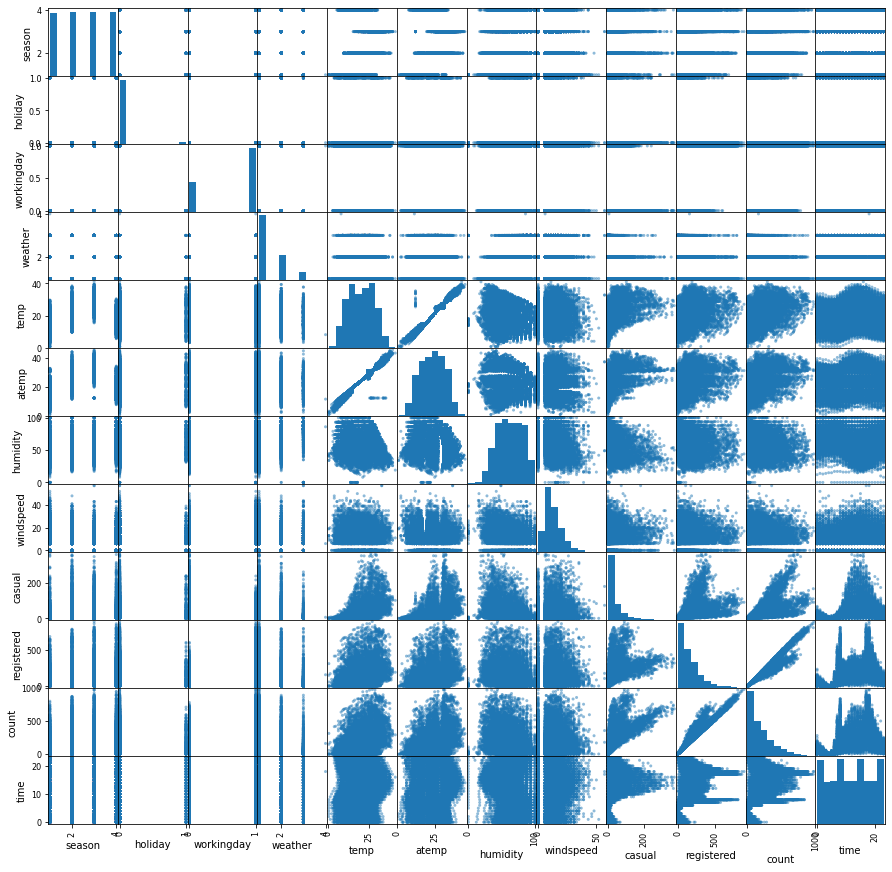

In [4]:
df["time"] = df["datetime"].apply(lambda x: int(x[-8:-6]))
pd.plotting.scatter_matrix(df, figsize=(15, 15))
plt.show()

## Preprocessing

In [48]:
train_df = (df
    .assign(time=df["datetime"].apply(lambda x: int(x[-8:-6])))
    .drop(columns=["datetime", "temp", "workingday", "season", "casual", "registered", "count"])
)
# train_df = df.loc[:, ~df.columns.isin(["casual", "registered", "count"])]

# one-hot にしない．（標準化したときにめんどくさくなる）
# train_df = pd.get_dummies(train_df, drop_first=True, columns=["weather"])

# holidayのstdが0に丸められてしまうので，いったん消す
train_df = train_df.drop(columns=["holiday"])

In [55]:
train_df

,weather,atemp,humidity,windspeed,time
0,1,14.395,81,0.0000,0
1,1,13.635,80,0.0000,1
2,1,13.635,80,0.0000,2
3,1,14.395,75,0.0000,3
4,1,14.395,75,0.0000,4
...,...,...,...,...,...
10881,1,19.695,50,26.0027,19
10882,1,17.425,57,15.0013,20
10883,1,15.910,61,15.0013,21
10884,1,17.425,61,6.0032,22


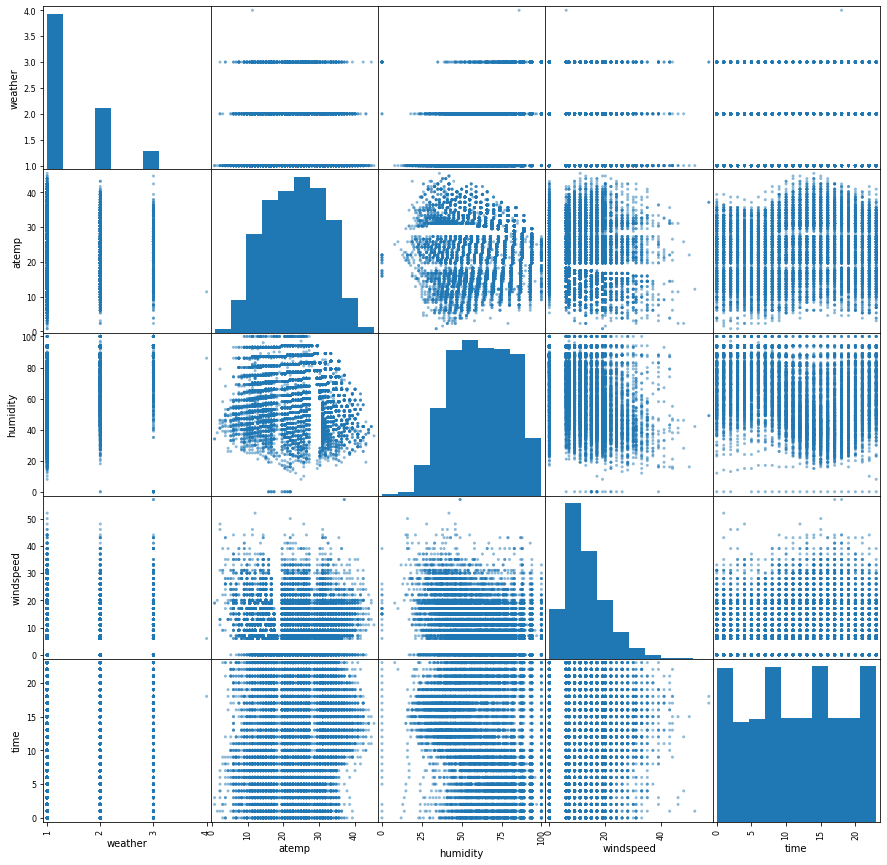

In [56]:
pd.plotting.scatter_matrix(train_df, figsize=(15, 15))
plt.show()

In [68]:
# X: (データサイズ)x(特徴量)
# X_transformed: (データサイズ)x(多項式にした特徴量)

class PolynomialRegression():
    def __init__(self, degree, epoch, lr=0.00001, is_analytical=True):
        self.degree = degree
        self.epoch = epoch
        self.lr = lr
        self.is_analytical = is_analytical

    def transform(self, X):
        # initialize X_transform
        X_transformed = X.copy()
        for i in range(1, self.degree + 1):
            X_transformed = np.hstack((X_transformed, np.power(X, i)))
        # print(f"X\n{X}\n")
        # print(f"X_transformed\n{X_transformed}")
        return X_transformed
    # def transform(self, X):
    #     # initialize X_transform
    #     X_transformed = np.ones((X.shape[0], 1))
    #     for i in range(1, self.degree + 1):
    #         X_transformed = np.concatenate((X_transformed, np.power(X, i)), axis=1)
    #     return X_transformed

    def normalize(self, X):
        return (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)

    def fit(self, X, y):
        y = y.reshape(-1, 1)
        
        # initialize weights
        X_transformed = self.transform(X)
        X_normalized = self.normalize(X_transformed)
        if np.linalg.det(X_normalized.T @ X_normalized) != 0 and self.is_analytical:
            # self.W = np.dot(np.dot(np.linalg.inv(np.dot(X_normalized.T, X_normalized)), X_normalized.T), y)
            self.W = np.linalg.inv(X_normalized.T @ X_normalized) @ X_normalized.T @ y
            print("solve analytically")
            
        # gradient descent
        else:
            self.W = np.random.rand(X_transformed.shape[1], 1)
            # self.W = np.zeros((X_transformed.shape[1], 1))
            for i in range(self.epoch):
                y_hat = self.predict(X, is_train=True)
                error = y_hat - y
                self.W -= self.lr / (i**2 + 1) * np.dot(X_normalized.T, error)
            print("solve numerically")
        return self

    def predict(self, X, is_train=False):
        X_transformed = self.transform(X)
        if not is_train:
            X_normalized = self.normalize(X_transformed)
            return np.dot(X_normalized, self.W)
        return np.dot(X_transformed, self.W)

In [69]:
train_df.shape

(10886, 5)

In [70]:
normalized_train_df = (train_df - train_df.mean()) / train_df.std()
train_X = normalized_train_df.to_numpy()
train_y = df["count"].to_numpy()

model = PolynomialRegression(degree=2, lr=0.00001, epoch=1000, is_analytical=True)
model.fit(train_X, train_y)
y_hat = model.predict(train_X,)

solve numerically


In [71]:
train_X.shape

(10886, 5)

In [63]:
print(y_hat)
print(train_y)

[[-126.04603936]
 [-116.38219037]
 [-105.89502898]
 ...
 [   7.79343444]
 [   3.03469827]
 [  -4.8566064 ]]
[ 16  40  32 ... 168 129  88]


## 基底関数をlogにしてみる

In [ ]:
train_data = train_df.to_numpy()
train_df_log = np.log(train_data + np.ones((train_data.shape[0], train_data.shape[1])))
normalized_train_df_log = (train_df_log - train_df_log.mean()) / train_df_log.std()
train_X_log = normalized_train_df_log
train_y_log = df["count"].to_numpy()

In [64]:
model_log = PolynomialRegression(degree=3, lr=0.0001, epoch=500, is_analytical=False)
model_log.fit(train_X_log, train_y)
y_hat = model_log.predict(train_X_log)
print(y_hat)
print(train_y)

array([[  -7.33027822],
       [ -31.34845916],
       [ -23.37431049],
       ...,
       [-157.44209273],
       [-119.52245284],
       [ -77.5495285 ]])

array([[6043.58709995],
       [5960.49032188],
       [5973.8906142 ],
       ...,
       [5016.45378676],
       [5075.41135516],
       [5358.95557084]])

array([[-90165.96191082],
       [-89019.61793904],
       [-88950.87658688],
       ...,
       [-73731.3176558 ],
       [-74050.86523964],
       [-77807.4701883 ]])

array([[480086.70338389],
       [473958.43994905],
       [473706.63471862],
       ...,
       [392918.45426414],
       [394883.38059549],
       [415082.55353492]])

array([[-1038580.99091041],
       [-1025333.26549257],
       [-1024729.82986413],
       ...,
       [ -849841.49177456],
       [ -853955.76939494],
       [ -897553.43923066]])

array([[893832.60412041],
       [882426.28551819],
       [881941.93059949],
       ...,
       [731496.13113234],
       [735118.44601261],
       [772698.67819

In [53]:
train_data

array([[ 0.   , 14.395, 81.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 13.635, 80.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 13.635, 80.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   , 15.91 , 61.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 17.425, 61.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 16.665, 66.   , ...,  0.   ,  0.   ,  0.   ]])

In [44]:
normalized_train_df

,holiday,atemp,humidity,windspeed,time,weather_2,weather_3,weather_4
0,-0.171483,-1.092687,0.993167,-1.567682,-1.668867,-0.593237,-0.292679,-0.009584
1,-0.171483,-1.182367,0.941206,-1.567682,-1.524271,-0.593237,-0.292679,-0.009584
2,-0.171483,-1.182367,0.941206,-1.567682,-1.379676,-0.593237,-0.292679,-0.009584
3,-0.171483,-1.092687,0.681399,-1.567682,-1.235080,-0.593237,-0.292679,-0.009584
4,-0.171483,-1.092687,0.681399,-1.567682,-1.090484,-0.593237,-0.292679,-0.009584
...,...,...,...,...,...,...,...,...
10881,-0.171483,-0.467289,-0.617638,1.617153,1.078450,-0.593237,-0.292679,-0.009584
10882,-0.171483,-0.735148,-0.253908,0.269691,1.223046,-0.593237,-0.292679,-0.009584
10883,-0.171483,-0.913917,-0.046062,0.269691,1.367641,-0.593237,-0.292679,-0.009584
10884,-0.171483,-0.735148,-0.046062,-0.832404,1.512237,-0.593237,-0.292679,-0.009584
